In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:

def add_noise(net, rate=50, weight=0.1, rng_seed=0):
    # Initialize random number generator for integers
    rng = np.random.default_rng(rng_seed)
    seed_array = rng.integers(0, 1000000, size=1000)

    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[0], conn_seed=seed_array[1])

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[2], conn_seed=seed_array[3])

In [3]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net_train = calcium_model(params)
# net_validation = net_train.copy()
add_noise(net_train, rng_seed=10)
# add_noise(net_validation, rng_seed=1)


dt = 0.5
dpl_train = simulate_dipole(net_train, dt=dt, tstop=2000, record_vsec='all', record_isec='all')
# dpl_validation = simulate_dipole(net_validation, dt=dt, tstop=1000, record_vsec='all', record_isec='all')

In [ ]:
dataset_cell_type = 'L5_pyramidal'
training_set = utils.CellType_Dataset_Fast(net_train, cell_type=dataset_cell_type, window_size=500, data_step_size=500, device='cpu')

In [ ]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, kernel_size=200, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.kernel_size = kernel_size

        self.tau1, self.tau2 = 10, 20
        self.kernel = self.get_kernel(torch.arange(0, kernel_size, 1),
                                      tau1=self.tau1, tau2=self.tau2).float().to(self.device).flip(0)

        # LSTM Layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        self.fc_input = nn.Sequential(
            nn.Linear(input_size, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh()
        )

        self.fc_output = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
    
        kernel_product = self.kernel.tile(dims=(batch_size, self.input_size, 1)).transpose(1,2)

        out = (kernel_product * x).sum(dim=1).unsqueeze(1)
        # print(out.shape)

        out = self.fc_input(out.contiguous())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc_output(out)
            
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    
        return hidden

    def get_kernel(self, t_vec, tau1=10, tau2=20):
        G = tau2/(tau2-tau1)*(-torch.exp(-t_vec/tau1) + torch.exp(-t_vec/tau2))
        return G

In [ ]:
L5Pyr_model = model_lstm(input_size=training_set[0][0].shape[1], output_size=training_set[0][1].shape[1], device=device).to(device)
L5Pyr_model.load_state_dict(torch.load('L5_pyramidal_model.pt'))

<All keys matched successfully>

In [ ]:
def get_drive_indices(drive_name, receptor, training_set, net):
    if drive_name == 'soma':
        drive_loc = ['soma']
    else:
        drive_loc = net.cell_types['L5_pyramidal'].sect_loc[drive_name]
    syn_names = [f'{loc}_{receptor}' for loc in drive_loc]
    syn_indices = np.where(np.in1d(training_set.isec_names, syn_names))[0]

    return syn_indices
    


In [ ]:
#LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, net, L5Pyr_model, training_set, n_L5Pyr=100, n_inhib=30, soma_idx=-1, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.net = net
        self.L5Pyr_model = L5Pyr_model
        self.training_set = training_set
        self.device = device

        self.n_L5Pyr = n_L5Pyr
        self.n_inhib = n_inhib
        # self.n_inhib = 0

        self.L5Pyr_gids = torch.tensor(list(range(0,n_L5Pyr)))
        self.inhib_gids = torch.tensor(list(range(n_L5Pyr, n_L5Pyr+n_inhib)))
        self.n_cells = n_L5Pyr + n_inhib

        self.drive_target_gids = None


        self.threshold = 3.0
        self.soma_idx = soma_idx  # index of soma compartment

        self.prox_indices = get_drive_indices('proximal', 'ampa', self.training_set, self.net)
        self.inhib_indices = get_drive_indices('soma', 'gabaa', self.training_set, self.net)

        self.conn_mean = torch.tensor([5.0, 5.0, 5.0, 5.0])
        self.conn_std = torch.tensor([1.0, 1.0, 1.0, 1.0])

        # weight_matrix =  self.init_weight_matrix().detach().requires_grad_(True)
        weight_matrix = torch.zeros((self.n_cells, self.L5Pyr_model.input_size, self.n_cells)).float().to(self.device)
    
        self.weight_matrix = nn.Parameter(weight_matrix).detach().to(self.device).requires_grad_(True)

    def forward(self, input_spikes_tensor):
        pred_y = list()
        hidden = self.L5Pyr_model.init_hidden(input_spikes_tensor.size(0))
        
        for time_idx in range(self.L5Pyr_model.kernel_size, input_spikes_tensor.size(1)-1):
            batch_x = input_spikes_tensor[:, time_idx-self.L5Pyr_model.kernel_size:time_idx, :].to(self.device)

            out, hidden = self.L5Pyr_model(batch_x, hidden)
            pred_y.append(out[:,-1, self.soma_idx])

            if time_idx > self.L5Pyr_model.kernel_size:
                spike_mask = ((pred_y[-1][:] > self.threshold) & (pred_y[-2][:] < self.threshold))
            
                input_spikes_tensor[:, time_idx+1, :] += torch.matmul(self.weight_matrix.clamp(0, 10), spike_mask.float())

        pred_y = torch.stack(pred_y)
        return pred_y


    def init_weight_matrix(self):
        weight_matrix = torch.zeros((self.n_cells, self.L5Pyr_model.input_size, self.n_cells)).float().to(self.device)

        # EE
        weight_matrix = self.random_weight_matrix(n_cells=self.n_cells, n_sec=self.L5Pyr_model.input_size, sec_indices=self.prox_indices,
                                     src_size=self.n_L5Pyr, target_size=5, src_range=self.L5Pyr_gids, target_range=self.L5Pyr_gids,
                                     weight_matrix=weight_matrix, mean_weight=self.conn_mean[0])
       # EI
        weight_matrix = self.random_weight_matrix(n_cells=self.n_cells, n_sec=self.L5Pyr_model.input_size, sec_indices=self.prox_indices,
                                                src_size=self.n_L5Pyr, target_size=30, src_range=self.L5Pyr_gids, target_range=self.inhib_gids,
                                                weight_matrix=weight_matrix, mean_weight=self.conn_mean[1])

        # IE
        weight_matrix = self.random_weight_matrix(n_cells=self.n_cells, n_sec=self.L5Pyr_model.input_size, sec_indices=self.inhib_indices,
                                                src_size=self.n_inhib, target_size=100, src_range=self.inhib_gids, target_range=self.L5Pyr_gids,
                                                weight_matrix=weight_matrix, mean_weight=self.conn_mean[2])

        # II
        weight_matrix = self.random_weight_matrix(n_cells=self.n_cells, n_sec=self.L5Pyr_model.input_size, sec_indices=self.inhib_indices,
                                                src_size=self.n_inhib, target_size=30, src_range=self.inhib_gids, target_range=self.inhib_gids,
                                                weight_matrix=weight_matrix, mean_weight=self.conn_mean[3])


        return weight_matrix

    def random_weight_matrix(self, n_cells, n_sec, sec_indices, src_size=100, target_size=100,
                           src_range=None, target_range=None, mean_weight=5., weight_matrix=None):
        if weight_matrix is None:
            weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()
        
        if src_range is None:
            src_range = list(range(n_cells))

        if target_range is None:
            target_range = list(range(n_cells))

        # src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
        src_probs = torch.ones(size=(len(src_range),))
        src_indices = torch.multinomial(src_probs, num_samples=src_size, replacement=False)
        src_gid_list = torch.index_select(src_range, dim=0, index=src_indices)

        for src_gid in src_gid_list:
            target_probs = torch.ones(size=(len(target_range),))
            target_indices = torch.multinomial(target_probs, num_samples=target_size, replacement=False)
            target_gid_list = torch.index_select(target_range, dim=0, index=target_indices)

            for target_gid in target_gid_list:
                weight_matrix[target_gid, sec_indices, src_gid] += torch.normal(mean=mean_weight, std=1.0)
        return weight_matrix

    # Create input spike train
    def init_input_spikes(self, n_samples=1000):
        input_spikes = torch.zeros((self.n_cells, n_samples + 1, len(training_set.isec_names)))

        # prox_time_indices = np.arange(0, n_samples, 1000)  # 1 Hz input

        self.drive_target_gids = np.random.choice(self.L5Pyr_gids, size=30, replace=False)
        for gid in self.drive_target_gids:
            prox_time_indices = np.random.choice(list(range(0, n_samples)), size=100, replace=False)
            # prox_time_indices = torch.randint(0, n_samples, size=(100,), requires_grad=True, )
            drive_weight = np.random.uniform(0, 10)
            for isec_idx in self.prox_indices:
                input_spikes[gid, prox_time_indices, isec_idx] = drive_weight

        return input_spikes

In [ ]:
model = model_network(net_train, L5Pyr_model, training_set, device=device).to(device)

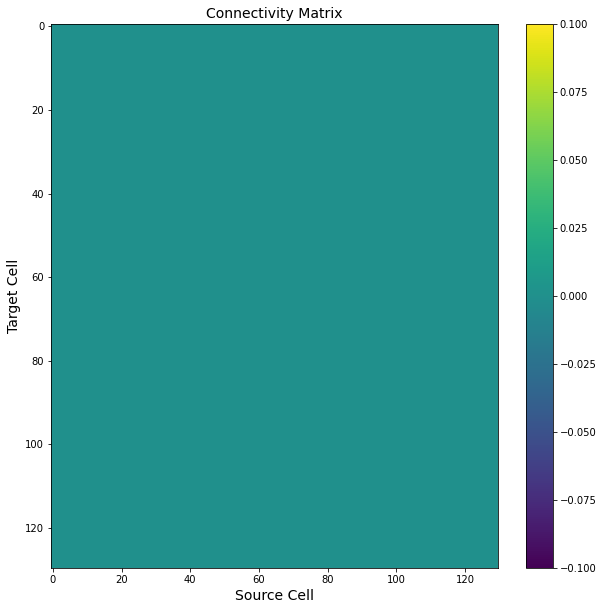

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(model.weight_matrix.detach().cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)
plt.colorbar()

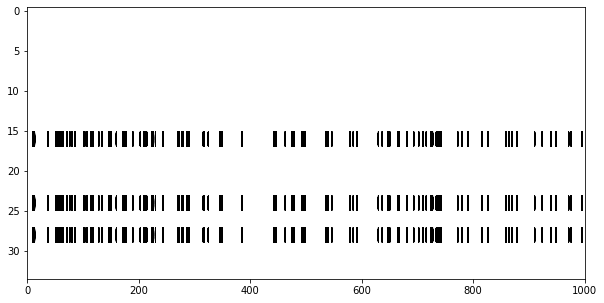

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(model.init_input_spikes()[model.drive_target_gids[0],:,:].T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0005)

In [ ]:
# weight_tensor = torch.from_numpy(weight_matrix).clone().detach().to(device).requires_grad_(True)
# weight_param = nn.ParameterList([weight_matrix.clone()]).to(device)

lr = 1
weight_decay = 0

# Create Gradient mask
# gradient_mask = torch.zeros(model.weight_matrix.size()).to(device)
# gradient_mask[model.weight_matrix > 0] = 1.0
# model.weight_matrix.register_hook(lambda grad: grad.mul_(gradient_mask))

optimizer = torch.optim.Adam([model.weight_matrix], lr=lr, weight_decay=weight_decay)


In [ ]:
print_freq = 10

max_epochs = 1000

input_spikes_init = model.init_input_spikes(n_samples=1000)
losses = list()
for epoch in range(max_epochs):
    # L5pyr_model.train()
    model.train()
    optimizer.zero_grad()
    input_spikes = input_spikes_init.clone().to(device).requires_grad_(False)

    pred_y = model(input_spikes)

    avg_soma = torch.mean(pred_y, axis=1)
    out_fft = torch.fft.rfft(avg_soma).abs()
    freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)


    power = torch.sum(out_fft[torch.logical_and(freq > 25, freq < 30)])
    total_power = torch.sum(out_fft[torch.logical_and(freq > 1, freq < 100)])

    relative_power = - (power / total_power)
    # relative_power = - power
    losses.append(relative_power.item())

    relative_power.backward()
    optimizer.step()

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')


*********
Epoch: 10/1000 ... Relative Power: 0.0038
****

(0.0, 100.0)

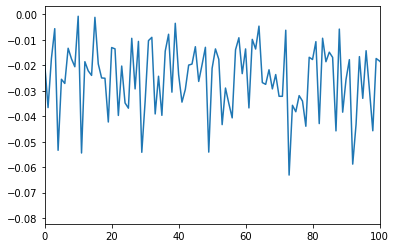

In [ ]:
plt.plot(losses)
plt.xlim(0,100)

(1.0, 100.0)

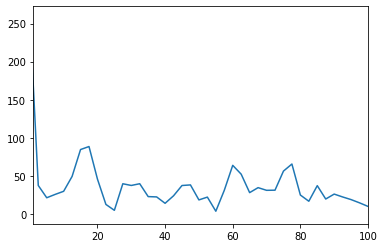

In [ ]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(1, 100)

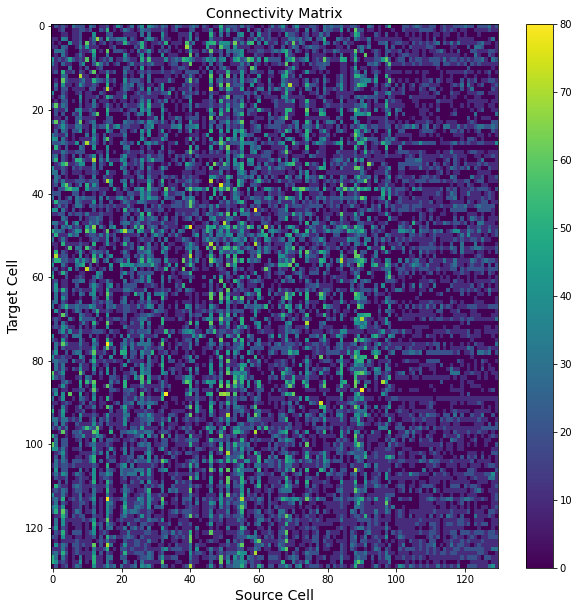

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(model.weight_matrix.detach().clamp(0,10).cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)
plt.colorbar()

In [ ]:
with torch.no_grad():
    model.eval()
    input_spikes = model.init_input_spikes(n_samples=1000).to(device).requires_grad_(False)
    pred_y = model(input_spikes).unsqueeze(2)
pred_y_np = pred_y.detach().cpu().numpy()

    
    

Text(0.5, 0, 'Time (ms)')

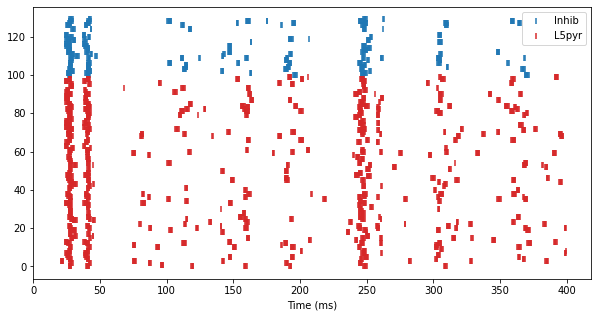

In [ ]:
cell_spikes = pred_y_np > 3.0
cell_spike_indices = np.where(cell_spikes > 0)
L5pyr_mask, inhib_mask = np.in1d(cell_spike_indices[1], model.L5Pyr_gids), np.in1d(cell_spike_indices[1], model.inhib_gids)
L5pyr_spikes = (cell_spike_indices[1][L5pyr_mask], cell_spike_indices[0][L5pyr_mask])
inhib_spikes = (cell_spike_indices[1][inhib_mask], cell_spike_indices[0][inhib_mask])

plt.figure(figsize=(10, 5))
plt.scatter(inhib_spikes[1] * dt, inhib_spikes[0], c='C0', marker='|', label='Inhib')
plt.scatter(L5pyr_spikes[1] * dt, L5pyr_spikes[0], c='C3', marker='|', label='L5pyr')
plt.xlim(0, None)
plt.legend()
plt.xlabel('Time (ms)')

IndexError: index 1 is out of bounds for axis 2 with size 1

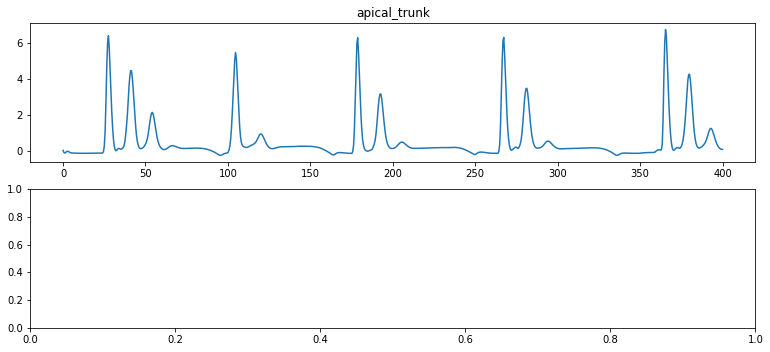

In [ ]:
output_size = len(training_set.vsec_names)
tvec = np.linspace(0, pred_y_np.shape[0] * dt, pred_y_np.shape[0])
plt.figure(figsize=(13, 3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, pred_y_np[:, 1, idx], color=f'C{idx}', label='Predicted Voltage')
    # plt.xlim(2000, 4000)
    plt.title(training_set.vsec_names[idx])
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

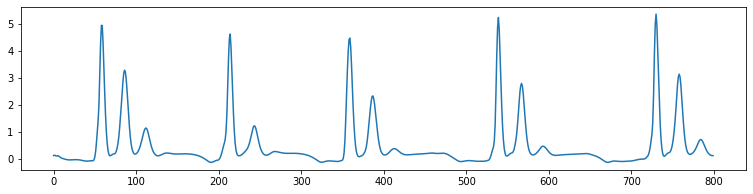

In [ ]:
plt.figure(figsize=(13, 3))
plt.plot(np.mean(pred_y_np[:, :,-1], axis=1))

In [ ]:
pred_y.shape

torch.Size([800, 130, 1])

In [ ]:
# def random_weight_matrix(n_cells, n_sec, sec_indices, src_size=100, target_size=100,
#                          src_range=None, target_range=None, max_weight=10, weight_matrix=None):
#     if weight_matrix is None:
#         weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()

    
#     if src_range is None:
#         src_range = list(range(n_cells))

#     if target_range is None:
#         target_range = list(range(n_cells))

#     src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
#     for src_gid in src_gid_list:
#         target_gid_list = np.random.choice(target_range, size=target_size, replace=False)
#         for target_gid in target_gid_list:
#             # print(weight_matrix)
#             weight_matrix[target_gid, sec_indices, src_gid] += np.random.uniform(0,max_weight)
#     return weight_matrix

# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=prox_indices,
#                                      src_size=n_L5Pyr, target_size=5, src_range=L5pyr_gids)
                                     
# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=inhib_indices,
#                                      src_size=n_inhib, target_size=100, src_range=inhib_gids, weight_matrix=weight_matrix)